In [1]:
import os
import sys
sys.path.append('..')
import radio
import radio.annotation
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


## Reading annotation file

Submodule **radio.utils** contains **read_nodules** function that accepts path to annotation file as it's first argument:

In [2]:
annotation_path = '/notebooks/data/CT/npcmr/ct_annotation/08_annotation.txt'
dicom_path = '/notebooks/data/CT/npcmr/08/*/*/*/*/*'
blosc_path = '/notebooks/ct/npcmr_blosc/*'

In [3]:
nodules = radio.annotation.read_nodules(annotation_path)
nodules.head(10)

,DoctorID,NoduleID,NoduleType,coordX,coordY,coordZ,diameter_mm,seriesid
40,002,60753926bd11ba3ff6da,solid,410.0,274.0,330.0,9.0,AGFA000000061588
41,002,85dfda222eace23f3c85,semi_solid,144.0,355.0,221.0,5.0,AGFA000000061588
45,002,9004928a6ff6b83f3824,solid,163.0,152.0,134.0,5.0,AGFA000000061588
46,002,9ea0a868b118ec3f8c14,semi_solid,159.0,162.0,133.0,4.0,AGFA000000061588
80,005,42ad81d03753dc3fb8db,semi_solid,412.0,273.0,330.0,9.0,AGFA000000061588
120,010,90f1037b841aae3f5c96,solid,410.0,273.0,331.0,9.0,AGFA000000061588
122,010,e7f6cbcc25a5e33fc429,solid,202.0,165.0,203.0,8.0,AGFA000000061588
123,010,bdf279f4d118e93f34bd,solid,192.0,211.0,195.0,5.0,AGFA000000061588
124,010,2dca280ec259eb3fa090,solid,183.0,325.0,143.0,5.0,AGFA000000061588
280,008,21127dd798eeeb3f9d75,solid,162.0,369.0,365.0,12.0,AGFA000000061613


If you need to get information about doctors that annotated each scan you can just use function **read_annotators_info**:

In [4]:
annotators = radio.annotation.read_annotators_info(annotation_path, annotator_prefix='doctor_')
annotators.head(10)

DoctorID,doctor_000,doctor_001,doctor_002,doctor_003,doctor_004,doctor_005,doctor_006,doctor_007,doctor_008,doctor_009,doctor_010,doctor_011,doctor_012,doctor_013,doctor_014
seriesid,,,,,,,,,,,,,,,
AGFA000000061588,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
AGFA000000061590,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
AGFA000000061613,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
AGFA000000061820,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
AGFA000000061951,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
AGFA000000062036,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
AGFA000000062311,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
AGFA000000062422,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
AGFA000000062507,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


Each row in **annotators** dataframe corresponds to AccessionNumber and represents those doctors who were annotating corresponding scan.

## Plotting distribution of nodules among doctors

Below you can find code that plots bar chart for number of nodules that were annotated by each doctor:

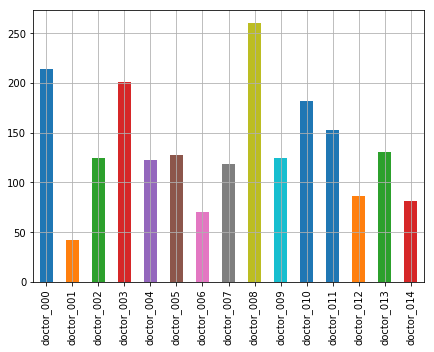

In [5]:
plt.figure(figsize=(7, 5))
ax = (
    nodules
    .set_index('seriesid')
    .merge(annotators, left_index=True, right_index=True)
    .filter(regex='doctor_\d{3}', axis=1)
    .unstack()
    .groupby(level=0)
    .sum()
    .plot(kind='bar', grid=True)
)

You can use **assign_nodules_group_index** function to add column *GroupNoduleID* that contains the same values
for different overlapping nodules(commonly, that group of overlapping nodules is just annotations from different doctors):

**Note**: before assigning nodules group index and uniting them into group you need to check that **[coordX, coordY, coordZ]** columns contain coordintates in mm. If coordinates provided in pixel scale you can make the following transform:

In [6]:
dataset_info = (
    radio.annotation.read_dataset_info(blosc_path, index_col=None, fmt='blosc')
    .drop_duplicates(subset=['seriesid'])
    .set_index('seriesid')
)

nodules = (
    radio.annotation.read_nodules(annotation_path)
    .set_index('seriesid')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * dataset_info.loc[df.index, 'SpacingZ'] + dataset_info.loc[df.index, 'OriginZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * dataset_info.loc[df.index, 'SpacingY'] + dataset_info.loc[df.index, 'OriginY'],
            coordX=lambda df: df.loc[:, 'coordX'] * dataset_info.loc[df.index, 'SpacingX'] + dataset_info.loc[df.index, 'OriginX'])
    .reset_index()
)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


As you can see, additional information about spacing in dataset's scans is required to do that. It can be easily obtained using **radio.annotation.read_dataset_info** function.

In [7]:
from radio.annotation import assign_nodules_group_index

nodules_with_group_index = (
    nodules
    .set_index(['seriesid', 'NoduleID'])
    .groupby(level=0)
    .apply(assign_nodules_group_index)
    .reset_index()
)

In [8]:
nodules_with_group_index.head()

,seriesid,NoduleID,DoctorID,NoduleType,coordX,coordY,coordZ,diameter_mm,GroupNoduleID
0,AGFA000000061588,201ca4d76033a53f4be3,002,solid,105.3718,12.484,13.5,9.0,f842e711530edb3f5472
1,AGFA000000061588,be7bb9ffab0ed63fc4cf,002,semi_solid,-76.3062,67.807,-95.5,5.0,640ea0ab87c1e63fb481
2,AGFA000000061588,80f6bc43d2b9c73fa35c,002,solid,-63.3292,-70.842,-182.5,5.0,5490038b46efd43f4287
3,AGFA000000061588,08165ad15269bc3fce3c,002,semi_solid,-66.0612,-64.012,-183.5,4.0,10b6b56a39adda3f82c2
4,AGFA000000061588,4016128bf6668c3f08ae,005,semi_solid,106.7378,11.801,13.5,9.0,f842e711530edb3f5472


Let's plot number of nodules with different numbers of verifications for each doctor. Number of verifications represents number of overlapping nodules in group: 

<Figure size 504x360 with 0 Axes>

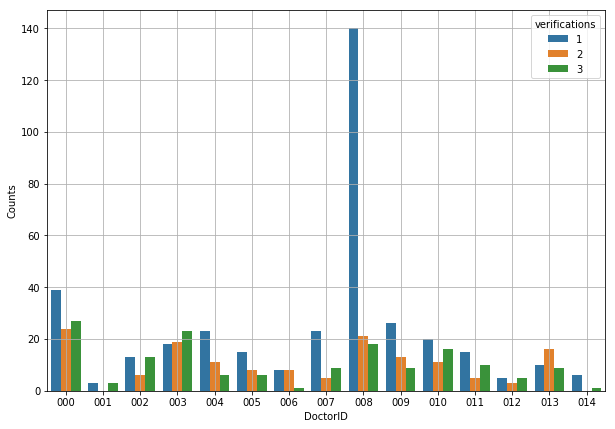

In [9]:
plt.figure(figsize=(7, 5))

data = (
    nodules_with_group_index
    .set_index('GroupNoduleID')
    .assign(verifications=lambda df: df.groupby(level=0).agg({'NoduleID': 'count'}))
    .groupby(['DoctorID', 'verifications'])
    .agg({'NoduleID': 'count'})
    .query('verifications <= 3')
    .reset_index()
)

plt.figure(figsize=(10, 7))
sns.barplot(x='DoctorID', y='NoduleID', hue='verifications', data=data)
plt.ylabel('Counts')
plt.grid(True)

## Gluing overlapping nodules together

Due to the fact that each cancer nodule can be annotated by several doctors we need to have a way to group overlapping nodules and then cover them with one big nodule. Generally, we also want to take into account different weights for different nodules. Function **glue_nodules** from **radio.annotation** will do this work for you. There are two conditions:
nodules dataframe must have confidence column that reflects the weight of nodule and **proba** parameter that is required for building normal-density approximation of covering nodule.

In [10]:
columns = ['SpacingZ', 'SpacingY', 'SpacingX', 'OriginZ', 'OriginY', 'OriginX']

group_nodules = (
    radio.annotation.read_nodules(annotation_path)
    .merge(dataset_info[columns].reset_index(), on='seriesid', how='inner')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * df.loc[df.index, 'SpacingZ'] + df.loc[df.index, 'OriginZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * df.loc[df.index, 'SpacingY'] + df.loc[df.index, 'OriginY'],
            coordX=lambda df: df.loc[:, 'coordX'] * df.loc[df.index, 'SpacingX'] + df.loc[df.index, 'OriginX'])
    .reset_index()
    .assign(NoduleConfidence=1)
    .drop(columns, axis=1)
    .pipe(radio.annotation.get_nodules_groups, proba=0.8)
)

In [11]:
group_nodules.head()

,GroupNoduleID,NoduleConfidence,coordX,coordY,coordZ,diameter_mm,seriesid
0,000fbbbc346f8a3f8483,1.0,-32.0108,42.423,-496.8000,4.000000,AGFA000000068349
1,0045152258f67d3f1a7c,1.0,-66.0612,-64.012,-183.5000,4.000000,AGFA000000061588
2,0056994da89c9f3f2ab5,1.0,-49.6603,58.660,-504.5000,5.500000,AGFA000000063927
3,005ee74d4cb0c83fa822,1.0,-28.8885,55.656,-470.7999,5.522681,AGFA000000069251
4,0067a4cf3251c73f2e08,1.0,-94.8956,-55.268,-488.0000,6.000000,AGFA000000068971


Source annotation contained more nodules then dataframe with glued nodules:

In [12]:
nodules.shape[0], group_nodules.shape[0]

(678, 453)

Number of nodules reduced because we united overlapping nodules within the group into one nodule.

## Computing doctors and nodules confidences

In [13]:
from radio.annotation import get_doctors_confidences
from radio.annotation import compute_nodule_confidence

nodules_with_confidences = (
    radio.annotation.read_nodules(annotation_path)
    .merge(dataset_info[columns].reset_index(), on='seriesid', how='inner')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * df.loc[df.index, 'SpacingZ'] + df.loc[df.index, 'OriginZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * df.loc[df.index, 'SpacingY'] + df.loc[df.index, 'OriginY'],
            coordX=lambda df: df.loc[:, 'coordX'] * df.loc[df.index, 'SpacingX'] + df.loc[df.index, 'OriginX'])
    .reset_index()
    .pipe(get_doctors_confidences, smooth=4, n_iters=8)
    .pipe(compute_nodule_confidence, alpha=0.5, weight_by_doctor=False)
    .pipe(radio.annotation.get_nodules_groups, proba=0.8)
)

100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Let's have a look at distribution of nodules' confidence after min-max scaling:

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


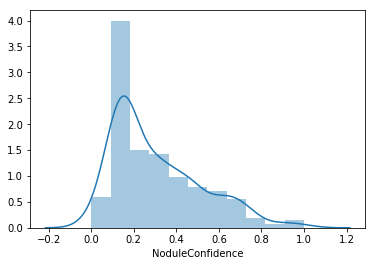

In [14]:
import seaborn as sns

x = nodules_with_confidences.NoduleConfidence
nodules_with_confidences.NoduleConfidence = (x - x.min()) / (x.max() - x.min())

sns.distplot(nodules_with_confidences.loc[:, 'NoduleConfidence'])

## Creating dicom dataset's FilesIndex and Dataset objects

In [15]:
from radio import dataset as ds
from radio.dataset import V, B, F

ct_index = ds.FilesIndex(dataset_info.index.values, paths=dict(dataset_info.loc[:, 'ScanPath']), dirs=True)
ct_dataset = ds.Dataset(ct_index, batch_class=radio.CTImagesMaskedBatch)

Remember that input dataframe for **fetch_nodules_info** actions requires *seriesuid* column:

In [16]:
ct_nodules = (
    radio.annotation.read_nodules(annotation_path)
)
ct_nodules.head()

,DoctorID,NoduleID,NoduleType,coordX,coordY,coordZ,diameter_mm,seriesid
40,002,00f17715b32fcb3f987b,solid,410.0,274.0,330.0,9.0,AGFA000000061588
41,002,40c66c129053b63fcc9d,semi_solid,144.0,355.0,221.0,5.0,AGFA000000061588
45,002,aa401fe7c994df3fee38,solid,163.0,152.0,134.0,5.0,AGFA000000061588
46,002,2444ce933e88e33f5262,semi_solid,159.0,162.0,133.0,4.0,AGFA000000061588
80,005,006f6acaea98b23f4020,semi_solid,412.0,273.0,330.0,9.0,AGFA000000061588


There is one major problem connected with annotation provided by radiologists: coordinates of nodules' centers are provided in pixel scale while diameter has 'mm' scale. If we simply put nodules as an argument of **fetch_nodules_info** function, we will get wrong masks. This could be avoided if both nodules' centers coordinates and diameter were provided in 'mm' scale. However in that case we would need to transform nodules dataframe using info about spacing and origin from all dataset. It is very expensive operation because fetching origin for all scans in dataset will require to read all CT scans in RAM. Fortunatelly, there is an alternative solution: transform coords 'on-the-fly' using F-named expression from dataset submodule in a combination with inverse transform using spacing and origin from batch:

In [17]:
def inverse_spacing_origin_transform(batch, nodules):
    """ Transform spacing and origin in nodules dataframe on fly. """
    indices = np.intersect1d(nodules.seriesuid.values, batch.indices)

    nodules = nodules.set_index('seriesuid')
    if len(indices) > 0:
        nodules = nodules.loc[indices, :]
        pos = batch.index.get_pos(nodules.index)

        nodules.loc[:, 'coordZ'] *= batch.spacing[pos, 0]
        nodules.loc[:, 'coordY'] *= batch.spacing[pos, 1]
        nodules.loc[:, 'coordX'] *= batch.spacing[pos, 2]

        nodules.loc[:, 'coordZ'] += batch.origin[pos, 0]
        nodules.loc[:, 'coordY'] += batch.origin[pos, 1]
        nodules.loc[:, 'coordX'] += batch.origin[pos, 2]

    return nodules.reset_index()

In [18]:
sample_nodules_ppl = ct_dataset >> (
    ds.Pipeline()
    .load(fmt='blosc', components=['images', 'spacing', 'origin'])
    .fetch_nodules_info(nodules=F(inverse_spacing_origin_transform, nodules=ct_nodules))
    .unify_spacing(shape=(400, 512, 512), spacing=(1.7, 1.0, 1.0), method='pil-simd')
    .normalize_hu()
    .create_mask()
    .sample_nodules(nodule_size=(32, 64, 64), batch_size=None, share=1.0)
)

If we want to use **group_nodules** dataframe that was created earlier, we don't need to transform coordinates using inverse spacing transform: we have already done this before computation of overlapping groups. In that case only inverse origin transform must be applied. As an alternative to this we can just set origin to zeros after loading scans:

In [19]:
sample_nodules_ppl = ct_dataset >> (
    ds.Pipeline()
    .load(fmt='blosc', components=['images', 'spacing', 'origin'])
    .fetch_nodules_info(nodules=group_nodules.assign(seriesuid=lambda df: df.loc[:, 'seriesid']))
    .normalize_hu()
    .create_mask()
    .sample_nodules(nodule_size=(32, 64, 64), batch_size=None, share=1.0)
)

Let's generate batch with crops sampled from two scans:

In [20]:
batch = sample_nodules_ppl.next_batch(batch_size=2)

Now we can plot obtained nodules and visually verify built masks:

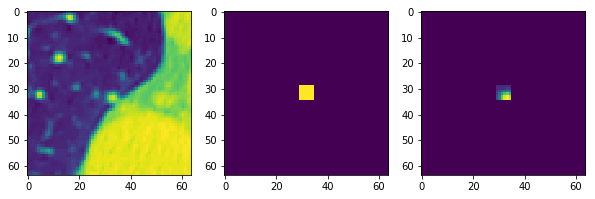

In [21]:
plt.figure(figsize=(10, 8))

image, mask = batch.get(2, 'images'), batch.get(2, 'masks')

ax_image = plt.subplot('131')
ax_image.imshow(image[16, :, :])

ax_mask = plt.subplot('132')
ax_mask.imshow(mask[16, :, :])

ax_mask_image = plt.subplot('133')
ax_mask_image.imshow(mask[16, :, :] * image[16, :, :])